# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [133]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [134]:
lines = np.loadtxt("../data/negative-words.txt", dtype='str', comments="#", delimiter=",", unpack=False)[200:300]
lines_count = [line + '_count' for line in lines]

print(lines)

['assult' 'astray' 'asunder' 'atrocious' 'atrocities' 'atrocity' 'atrophy'
 'attack' 'attacks' 'audacious' 'audaciously' 'audaciousness' 'audacity'
 'audiciously' 'austere' 'authoritarian' 'autocrat' 'autocratic'
 'avalanche' 'avarice' 'avaricious' 'avariciously' 'avenge' 'averse'
 'aversion' 'aweful' 'awful' 'awfully' 'awfulness' 'awkward' 'awkwardness'
 'ax' 'babble' 'back-logged' 'back-wood' 'back-woods' 'backache'
 'backaches' 'backaching' 'backbite' 'backbiting' 'backward'
 'backwardness' 'backwood' 'backwoods' 'bad' 'badly' 'baffle' 'baffled'
 'bafflement' 'baffling' 'bait' 'balk' 'banal' 'banalize' 'bane' 'banish'
 'banishment' 'bankrupt' 'barbarian' 'barbaric' 'barbarically' 'barbarity'
 'barbarous' 'barbarously' 'barren' 'baseless' 'bash' 'bashed' 'bashful'
 'bashing' 'bastard' 'bastards' 'battered' 'battering' 'batty' 'bearish'
 'beastly' 'bedlam' 'bedlamite' 'befoul' 'beg' 'beggar' 'beggarly'
 'begging' 'beguile' 'belabor' 'belated' 'beleaguer' 'belie' 'belittle'
 'belittled

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [135]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [136]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data_jeremy(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        cv = CountVectorizer(ngram_range=(1, 2))
        X_cv = cv.fit_transform(movie_data.review)
        fitted_transformations.append(cv)
#         print(v.fit(movie_data.review).vocabulary_)
        print("Shape of CountVectorizer X:")
        print(X_cv.shape)
    else: # transform() 
        X_cv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of CountVectorizer X:")
        print(X_cv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_cv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_cv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")
#     movie_data['doesn\'t_count'] = movie_data['review'].str.count("doesn't")
#     movie_data['does_not_count'] = movie_data['review'].str.count("does not")
    
#     print(p)
#     for word in lines:
#         movie_data[word + '_count'] = movie_data['review'].str.count(word)
    
#     movie_data['bad_count'] = movie_data['review'].str.count("bad")
#     movie_data['worst_count'] = movie_data['review'].str.count("worst")
#     movie_data['ellipsis_ratio'] = movie_data['review'].str.split('...').str.len() / movie_data['review'].str.split(' ').str.len()

#     X_quant_features = movie_data[["word_count", "punc_count", "bad_count", "worst_count", "ellipsis_ratio"]]
    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

In [137]:

# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [138]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../data/moviereviews_train.tsv', my_random_seed=999)

print("Number of fits stored in `fitted_transformations` list: ")
print(fitted_transformations)

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9


In [139]:
# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [140]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

/Users/jeremyodell/opt/anaconda3/envs/machineleaning/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(


{'Pos': 9965, 'Neg': 10035, 'TP': 4704, 'TN': 5292, 'FP': 4743, 'FN': 5261, 'Accuracy': 0.4998, 'Precision': 0.4979358526516354, 'Recall': 0.4720521826392373, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [141]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 9965, 'Neg': 10035, 'TP': 9965, 'TN': 10035, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [142]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 9965, 'Neg': 10035, 'TP': 9965, 'TN': 10035, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [143]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 9965, 'Neg': 10035, 'TP': 9546, 'TN': 9873, 'FP': 162, 'FN': 419, 'Accuracy': 0.97095, 'Precision': 0.9833127317676144, 'Recall': 0.9579528349222278, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [144]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9965, 'Neg': 10035, 'TP': 9965, 'TN': 10035, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [145]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=9999999.0)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9965, 'Neg': 10035, 'TP': 8684, 'TN': 9803, 'FP': 232, 'FN': 1281, 'Accuracy': 0.92435, 'Precision': 0.9739793629430238, 'Recall': 0.871450075263422, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [146]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 9965, 'Neg': 10035, 'TP': 7549, 'TN': 8079, 'FP': 1956, 'FN': 2416, 'Accuracy': 0.7814, 'Precision': 0.7942135718043135, 'Recall': 0.7575514300050176, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

In [147]:
# fits = [rdg_performance_train]

# for fit in fits:
#     plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
#     plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
# plt.axis([0, 1, 0, 1])
# plt.title('ROC plot: test set')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.show()

### Linear SVC with training data

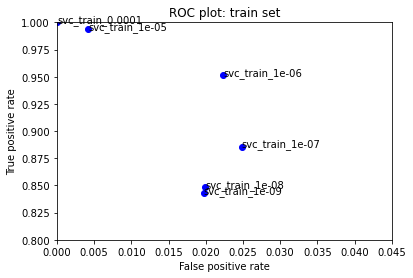

In [148]:
from sklearn.svm import LinearSVC

c_vals = [0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001, 0.000000001]
performance_measures = []

for c in c_vals:
    svc = LinearSVC(C=c)
    svc.fit(X_train, y_train)

    svc_performance_train = BinaryClassificationPerformance(svc.predict(X_train), y_train, 'svc_train_' + str(c))
    svc_performance_train.compute_measures()
    performance_measures.append(svc_performance_train)
    
for measure in performance_measures:
    plt.plot(measure.performance_measures['FP'] / measure.performance_measures['Neg'], 
             measure.performance_measures['TP'] / measure.performance_measures['Pos'], 'bo')
    plt.text(measure.performance_measures['FP'] / measure.performance_measures['Neg'], 
             measure.performance_measures['TP'] / measure.performance_measures['Pos'], measure.desc)
plt.axis([0, 0.045, 0.8, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()


### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [149]:
# ols_predictions = nbs.predict(X_train)

### let's look at some false positives:

In [150]:
# false positives

# print("Examples of false positives:")

# import random, time

# for i in range(0, len(ols_predictions)):
#     if (ols_predictions[i] == 1):
#         if (X_raw_train.iloc[i]['sentiment'] == 0):
#             if (random.uniform(0, 1) < 0.5): # to print only 5% of the false positives
#                 print(i)
#                 print(X_raw_train.iloc[i]['review'])
#                 print('* * * * * * * * * ')


---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [151]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2535, 'Neg': 2465, 'TP': 1144, 'TN': 1356, 'FP': 1109, 'FN': 1391, 'Accuracy': 0.5, 'Precision': 0.5077674212161563, 'Recall': 0.4512820512820513, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [152]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2535, 'Neg': 2465, 'TP': 2087, 'TN': 2083, 'FP': 382, 'FN': 448, 'Accuracy': 0.834, 'Precision': 0.8452814904819765, 'Recall': 0.8232741617357002, 'desc': 'svm_test'}


### MODEL: logistic regression

In [153]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2535, 'Neg': 2465, 'TP': 2128, 'TN': 2072, 'FP': 393, 'FN': 407, 'Accuracy': 0.84, 'Precision': 0.8441094803649345, 'Recall': 0.8394477317554241, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [154]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2535, 'Neg': 2465, 'TP': 1825, 'TN': 1833, 'FP': 632, 'FN': 710, 'Accuracy': 0.7316, 'Precision': 0.7427757427757428, 'Recall': 0.7199211045364892, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [155]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2535, 'Neg': 2465, 'TP': 2096, 'TN': 2066, 'FP': 399, 'FN': 439, 'Accuracy': 0.8324, 'Precision': 0.8400801603206413, 'Recall': 0.8268244575936884, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [156]:
# rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
# rdg_performance_test.compute_measures()
# print(rdg_performance_test.performance_measures)

### MODEL: Random Forest Classifier

In [157]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2535, 'Neg': 2465, 'TP': 1887, 'TN': 1911, 'FP': 554, 'FN': 648, 'Accuracy': 0.7596, 'Precision': 0.7730438344940598, 'Recall': 0.744378698224852, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

In [158]:
# fits = [rdg_performance_test]

# for fit in fits:
#     plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
#     plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
# plt.axis([0, 1, 0, 1])
# plt.title('ROC plot: test set')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.show()

### Linear SVC with test data

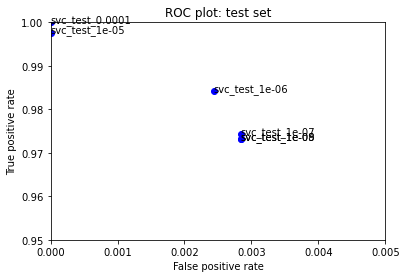

In [166]:
c_vals = [0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001, 0.000000001]
performance_measures = []

for c in c_vals:
    svc = LinearSVC(C=c)
    svc.fit(X_test, y_test)

    svc_performance_test = BinaryClassificationPerformance(svc.predict(X_test), y_test, 'svc_test_' + str(c))
    svc_performance_test.compute_measures()
    performance_measures.append(svc_performance_test)


for measure in performance_measures:
    plt.plot(measure.performance_measures['FP'] / measure.performance_measures['Neg'], 
             measure.performance_measures['TP'] / measure.performance_measures['Pos'], 'bo')
    plt.text(measure.performance_measures['FP'] / measure.performance_measures['Neg'], 
             measure.performance_measures['TP'] / measure.performance_measures['Pos'], measure.desc)
plt.axis([0, 0.005, 0.95, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()


---

# <span style="color:red">SUBMISSION</span>

---

In [160]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='../data/moviereviews_test.tsv', my_random_seed=999, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Size

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [161]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.45684


In [162]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [163]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,0
3,7186_2,1
4,12128_7,0


In [164]:
my_submission.shape

(25000, 2)

In [165]:
# export submission file as pdf
# CHANGE FILE PATH: 
# my_submission.to_csv('/home/ec2-user/data/moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation